In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image, ImageDraw, ImageFont
import zod_removal as zod

%matplotlib ipympl

# Parameters
Nx, Ny = 800, 600           # SLM pixels
wavelength = 632.8e-9       # meters (not explicitly used for scale in far field)
F = 0.3                     # meters (focal length)
pixel_pitch = 32e-6         # meters (not explicitly used in simulation, can be used for scaling ?)
fill_factor = .85
aperture_diameter = Ny      # pixels for flat top illumination
num_iterations = 10         # GS Iterations
oversample_factor = 20     # 20 to staht there is no cropping od the dead zone at fill_factor = 0.85

# Weight balancing and final phase mask generation
C_target = 1.0
# Example weight; iteratively, user may choose to scan this parameter
C_corr = 0.35


## Import the target

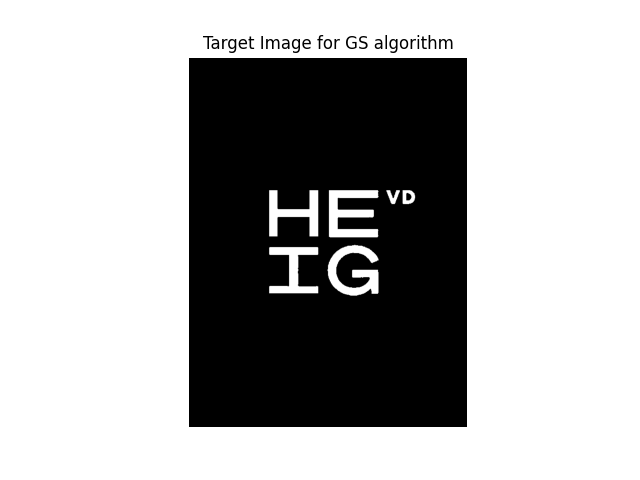

In [9]:

image_path = 'heig.png'  # Replace with your image file
img = Image.open(image_path).convert('L')  # Grayscale
# Resize to target resolution (Nx, Ny)
new_size = 450
img = img.resize((new_size,new_size))
# Convert to normalized numpy array
target_amplitude = np.zeros((Nx,Ny))
target_amplitude[Nx//2 -new_size//2:Nx//2 +new_size//2,Ny//2 -new_size//2:Ny//2 +new_size//2] = np.array(img) / 255.0
target_amplitude[target_amplitude >=.5] = 1
target_amplitude[target_amplitude<.5] = 0


plt.figure()
plt.imshow(target_amplitude, cmap='gray')
plt.title('Target Image for GS algorithm')
plt.axis('off')
plt.show()

## Aperture

In [10]:
# Create aperture mask
aperture_mask = zod.create_circular_aperture(Nx, Ny, aperture_diameter)
# aperture_mask = np.ones((Nx, Ny))
Nx_os, Ny_os = aperture_mask.shape



## ZOD phase

In [11]:
# Initialize amplitude_slm at oversampled resolution
amplitude_slm = aperture_mask

# Suppression of Zeroth-Order Diffraction in Phase-Only Spatial Light Modulator §1.3.1
target_amplitude_correction_aperture = zod.apply_fill_factor_with_oversampling(amplitude_slm,oversample_factor,fill_factor) # generating the dead-zones
target_amplitude_correction_aperture = (target_amplitude_correction_aperture-1)*(-1) #invert the ones and zeros

target_amplitude_correction = ((zod.depad(fft2(zod.zero_pad(target_amplitude_correction_aperture)),pad_factor=2))).real**2
target_amplitude_correction = zod.crop_oversampling((target_amplitude_correction-target_amplitude_correction.min())/(target_amplitude_correction.max()-target_amplitude_correction.min()),oversample_factor)

phi_corr = zod.gerchberg_saxton(target_amplitude_correction, amplitude_slm, iter=50) # should be target**(1/2) ?
zod_raw = zod.generate_far_field_intensity(phi_corr,amplitude_slm)



Text(0.5, 0.98, 'Zod correction simulation results')

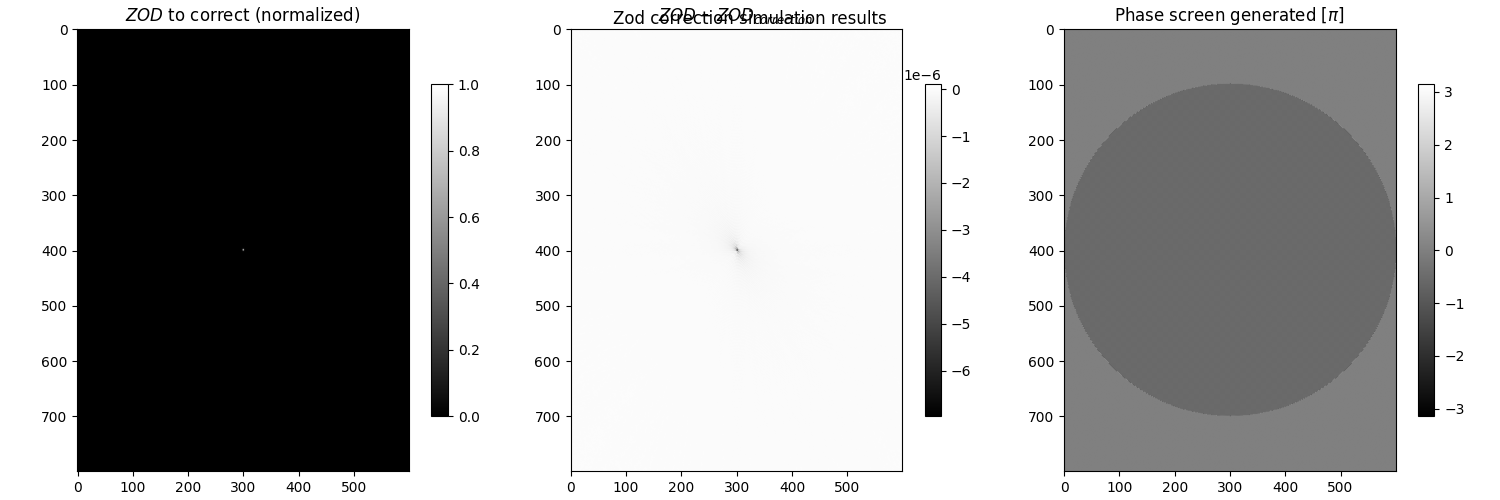

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
title = f"Zod correction simulation results"

im0 =axs[0].imshow(target_amplitude_correction, vmin = 0, vmax = 1,cmap='grey')
axs[0].set_title("$ZOD$ to correct (normalized)")
fig.colorbar(im0, ax=axs[0], shrink=0.75)

im1 = axs[1].imshow(target_amplitude_correction-zod_raw, cmap='grey')
axs[1].set_title("$ZOD - ZOD_{correction}$ ")
fig.colorbar(im1, ax=axs[1], shrink=0.75)


im2 = axs[2].imshow(phi_corr,vmin = -np.pi, vmax = np.pi,cmap='grey')
axs[2].set_title("Phase screen generated [$\\pi$]")
fig.colorbar(im2, ax=axs[2], shrink=0.75)
fig.tight_layout()
fig.suptitle(title)


## Compute phase for the target

In [13]:
# blank target for all spots removal only

target_amplitude1 = np.zeros((Nx, Ny))
target_amplitude1 = target_amplitude

print("Computing target hologram phase...")
phi_target = zod.gerchberg_saxton(target_amplitude1, amplitude_slm, iter=num_iterations)

Computing target hologram phase...


In [ ]:
print("Computing target hologram phase...")
phi_total = zod.compute_weighted_phase(C_corr, phi_corr, phi_target, amplitude_slm)
phi_total = phi_total*amplitude_slm
intensity_target = zod.generate_far_field_intensity(phi_target, amplitude_slm)/(wavelength*F)
intensity_total = zod.generate_far_field_intensity(phi_total, amplitude_slm)/(wavelength*F)


Computing target hologram phase (all spots off)...


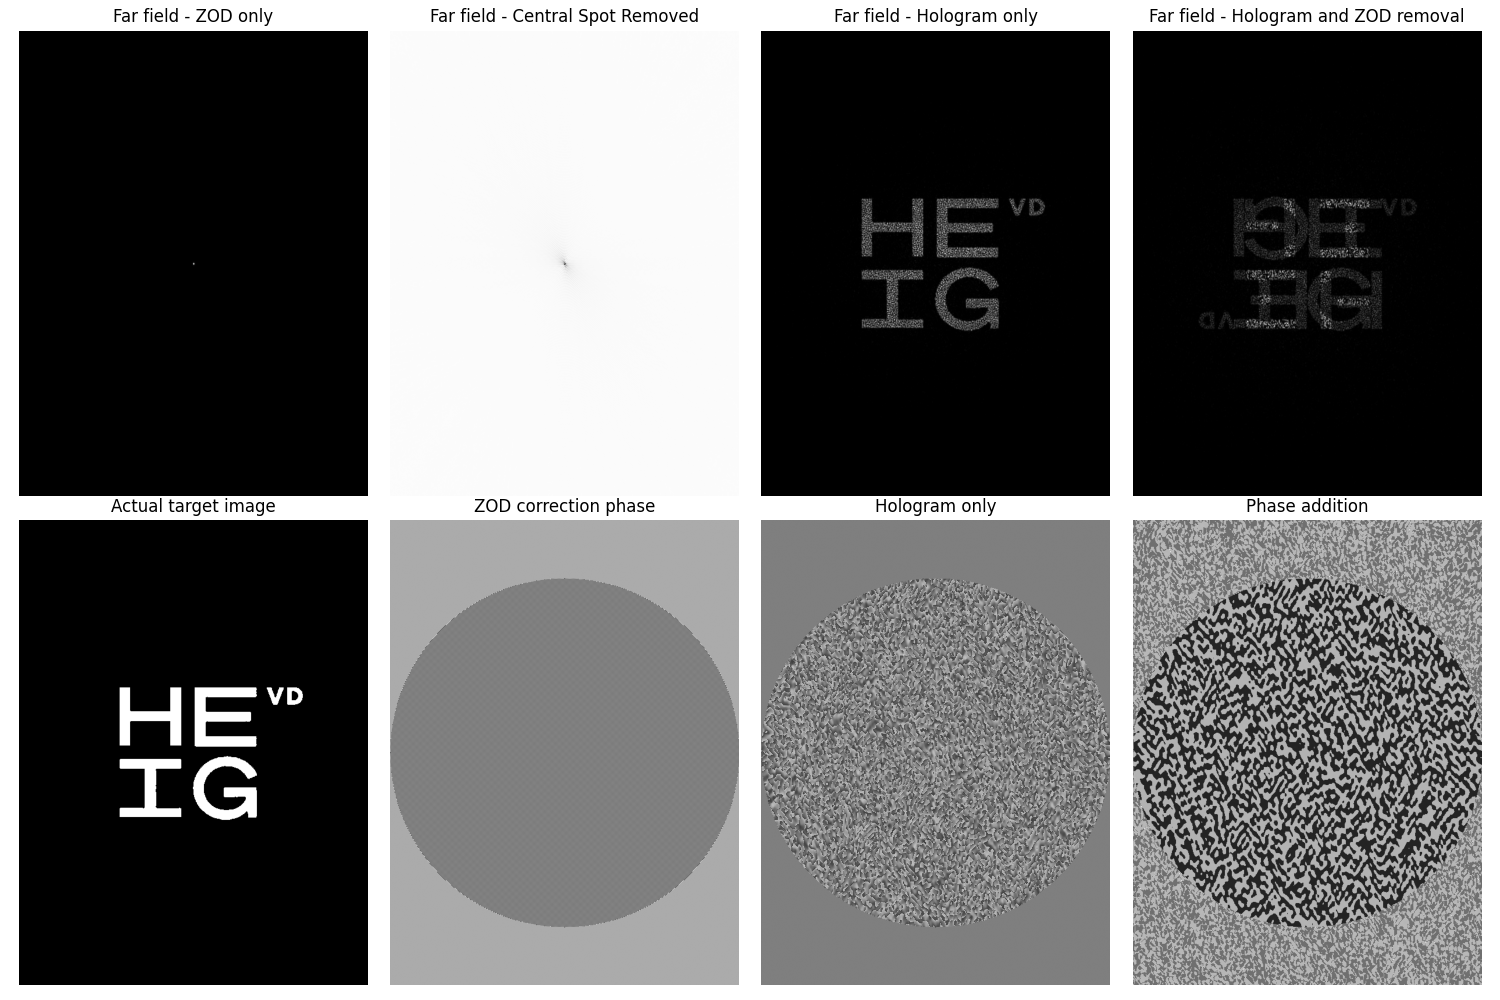

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(15, 10))


axs[0, 0].set_title("Far field - ZOD only")
axs[0, 0].imshow(target_amplitude_correction, cmap='grey')
axs[0, 0].axis('off')

axs[0, 1].set_title("Far field - Central Spot Removed")
axs[0, 1].imshow(target_amplitude_correction- zod_raw, cmap='grey')
axs[0, 1].axis('off')

axs[0, 2].set_title("Far field - Hologram only")
axs[0, 2].imshow(intensity_target, cmap='grey')
axs[0, 2].axis('off')

axs[0, 3].set_title("Far field - Hologram and ZOD removal")
axs[0, 3].imshow(intensity_total, cmap='grey')
axs[0, 3].axis('off')

axs[1, 0].set_title("Actual target image")
axs[1, 0].imshow(target_amplitude, cmap='grey')
axs[1, 0].axis('off')

axs[1, 1].set_title("ZOD correction phase")
axs[1, 1].imshow(phi_corr, cmap='grey')
axs[1, 1].axis('off')

axs[1, 2].set_title("Hologram only")
axs[1, 2].imshow(phi_target, cmap='grey')
axs[1, 2].axis('off')

axs[1, 3].set_title("Phase addition")
axs[1, 3].imshow(phi_total, cmap='grey')
axs[1, 3].axis('off')


plt.tight_layout()
plt.show()
